# **Reimplementation of : "DiffiT: Diffusion Vision Transformers for Image Generation"**

#### The following report is a detailed re-implementation of the paper  "DiffiT: Diffusion Vision Transformers for Image Generation".
#### The presented paper is an extension to the ViTs ( vision transformers ) applied to image generation in a diffusion process. In particular, the main innovation is the introduction of an alternative attention mechanism, the Time-Dependent Self-Attention (TMSA), with the goal of mantaining information about the diffusion timestep and the image labels without it vanishing throughtout the architectures.
#### The paper shows how the new attention mechanism is applied in two different architectures:

*   Image Space architecture
*   Latent space architecture



---



###### https://arxiv.org/pdf/2312.02139


# **SUPPORT CODE**
#### The following code is juts for support, so It's not important to the project presentation.

## **SETTINGS AND IMPORTS**
Load the hyperparameters saved in yaml files, import all the needed libraries and mount Google Drive to retrieve data.

In [ ]:
!pip install taming-transformers
!pip install torch-fidelity
!pip install torchmetrics[image]
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
  

In [ ]:
import os
import math
import datetime
from datetime import datetime
import pandas as pd
import yaml
from PIL import Image
import importlib
import shutil
import random

import torch
import torch.nn as nn
import torch.optim as optim
from timm.layers import PatchEmbed
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset , DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image

import numpy as np
from tqdm import tqdm
from enum import auto

import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters for image space model
img_config_file = '/content/drive/MyDrive/DiffiT_Data/settings/image_training_settings.yaml'
# Hyperparameters for latent space model
latent_config_file = '/content/drive/MyDrive/DiffiT_Data/settings/latent_training_settings.yaml'

In [ ]:
!git clone https://github.com/Koyote059/diffit-reimplementation.git

Cloning into 'diffit-reimplementation'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 111 (delta 32), reused 105 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (111/111), 543.28 KiB | 803.00 KiB/s, done.
Resolving deltas: 100% (32/32), done.


## **LOAD PARAMETERS**

In [ ]:
def validate_parameters(params: dict, param_types: dict) -> None:
    """
    Validates that the parameters dictionary contains all the required keys and that their types match the expected values.

    :param params: A dictionary containing the parameters loaded from a YAML file.
    :param param_types: A dictionary where keys are parameter names and values are expected types.
    :raises ValueError: If any required parameter is missing.
    :raises TypeError: If a parameter is of the wrong type.
    """
    missing_params = [param for param in param_types if param not in params]
    if missing_params:
        raise ValueError(f"Missing required parameters in YAML: {', '.join(missing_params)}")

    for param, expected_type in param_types.items():
        if not isinstance(params[param], expected_type):
            raise TypeError(
                f"Parameter '{param}' must be of type {expected_type.__name__}, but got {type(params[param]).__name__}.")


def load_parameters(config_file: str, param_types: dict) -> dict:
    """
    Loads and validates parameters from a YAML configuration file.

    :param config_file: Path to the YAML file containing training parameters.
    :param param_types: A dictionary where keys are parameter names and values are expected types.
    :return: A dictionary of parameters loaded from the file.
    :raises ValueError: If required parameters are missing.
    :raises TypeError: If parameters have incorrect types.
    """
    with open(config_file, 'r') as file:
        params = yaml.safe_load(file)

    # Define the expected types for each parameter
    validate_parameters(params, param_types)

    # Ensure test_size is within the valid range (0, 1)
    #if not (0 < params['test_size'] < 1):
    #    raise ValueError("Parameter 'test_size' must be a float between 0 and 1")

    return params

## **UTILS FUNCTIONS**

In [ ]:
def denormalize(img):
    img = (img.clamp(-1, 1) + 1) / 2 # bring values among 0 and 1
    return img

In [ ]:
def plot_images(images_tensor):
  """
  Plots a batch of images (batch_size, 3, 32, 32) using matplotlib.

  Args:
  images_tensor: Tensor of shape (batch_size, 3, 32, 32)

  """
  # Number of images in the batch
  batch_size = images_tensor.shape[0]

  # Bring pixels values among [0, 255]
  images_tensor = (images_tensor * 255).type(torch.uint8)

  # Create a figure with subplots (2 rows, 4 columns for 8 images)
  fig, axes = plt.subplots(1, 8, figsize=(15, 5))

  # Loop over the batch and plot each image
  for i, ax in enumerate(axes):
    # Convert to HWC format for plt
    img = images_tensor[i].permute(1, 2, 0).cpu().numpy()

    ax.imshow(img)
    # Hide axes
    ax.axis('off')

  # Adjust spacing
  plt.tight_layout()
  plt.show()

In [ ]:
def sample_top_classes(source_dir: str, target_dir: str, top_percentage: float = 0.1):
    """
    Select the top percentage of classes based on the number of images and save to a new dataset.

    :param source_dir: Path to the original dataset.
    :param target_dir: Path to save the smaller dataset.
    :param top_percentage: Percentage of classes to select (e.g., 0.1 for 10%).
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Count images in each class
    class_image_counts = {}
    for cls in os.listdir(source_dir):
        class_path = os.path.join(source_dir, cls)
        if os.path.isdir(class_path):
            class_image_counts[cls] = len(os.listdir(class_path))

    # Sort classes by number of images (descending)
    sorted_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)

    # Determine the number of classes to select
    num_classes_to_select = max(1, int(len(sorted_classes) * top_percentage))
    selected_classes = [cls[0] for cls in sorted_classes[:num_classes_to_select]]

    print(f"Selected top {top_percentage*100}% classes: {selected_classes}")

    # Copy selected classes to the new dataset
    source_class_dir = os.path.join(source_dir, cls)
    target_class_dir = os.path.join(target_dir, cls)
    shutil.copytree(source_class_dir, target_class_dir)

    print(f"Smaller dataset with top {top_percentage*100}% classes saved at {target_dir}.")

In [ ]:
import sys
sys.path.append('/content/diffit-reimplementation')

In [ ]:
def get_obj_from_str(string, reload=False):
  module, cls = string.rsplit(".", 1)
  if reload:
      module_imp = importlib.import_module(module)
      importlib.reload(module_imp)
  return getattr(importlib.import_module(module, package=None), cls)

In [ ]:
def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    print(config["target"])
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

# **DIFFUSION MODELS**
#### The generative models based on the diffusion process work on the following principles:
* **Forward process**: some noise is added gradually to an original image for a fixed number of steps, until it becomes pure noise.
* **Backward process**: given the pure noise, it's removed gradually for a fixed number of steps, until a new clear image is generated.
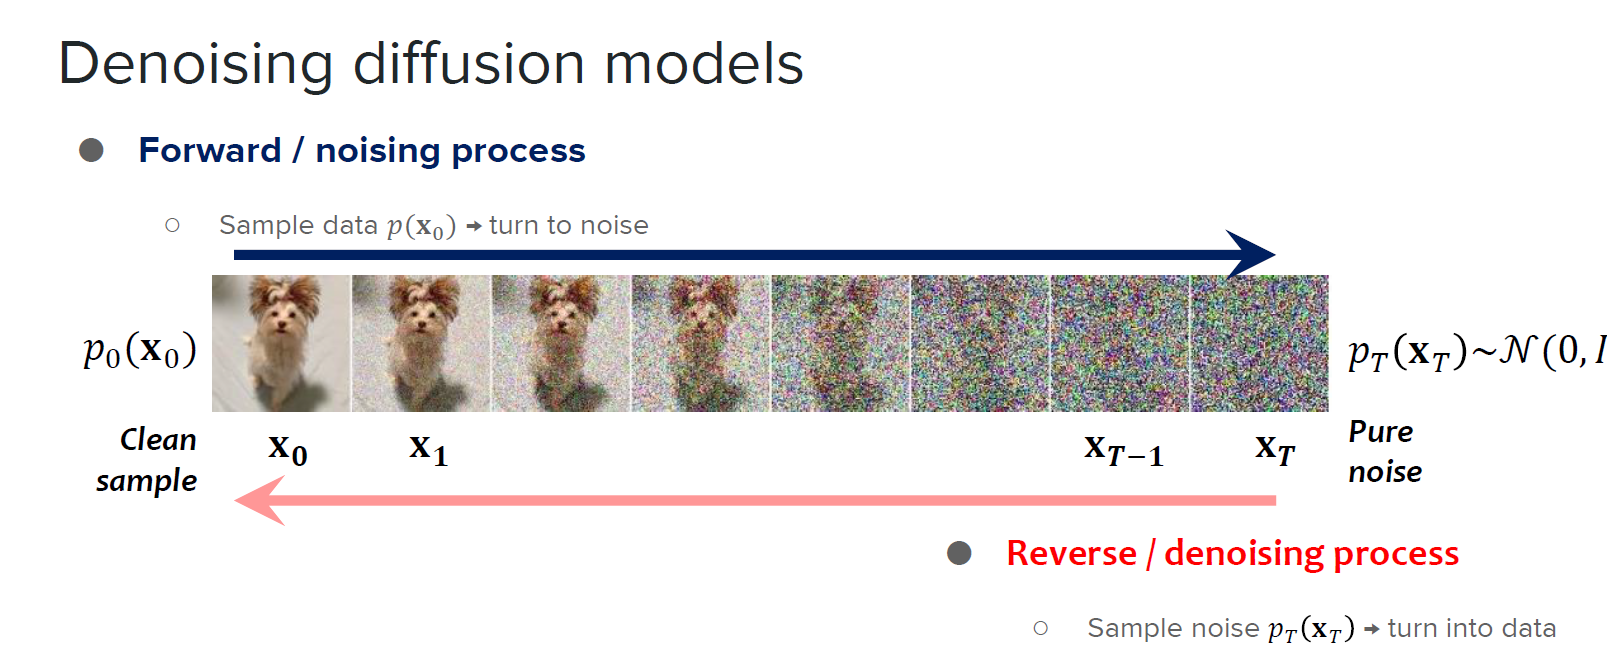

The goal of a diffusion model is to learn the noise to remove from the noisy image in order to obtain a clean image.

## **Noise Scheduler**

Here, we have implemented the mathematical steps needed to add and remove noise from an image. In particular:


*   **Noisify**: it characterizes the *forward process* (or *diffusion process*). Its role is to add Gaussian noise to the input sample with a mean and a standard deviation determined by the variance schedule \\(\mathbf(β_1, ..., β_T)\\), which controls how the data gradually degrades over time. Specifically, the noise is scaled using a timestep-dependent factor, ensuring a smooth transition from the original data to the pure noise.
This means that the sample at timestep t can be written as:
$$q(x_t | x_0) = N(x_t; \sqrt{\bar{\alpha_t}}x_0; (1 - \bar{\alpha_t})I)$$
where
$$\alpha_t := 1 - \beta_t$$ and $$\bar{a}_t := \prod_{s = 1}^t \alpha_s$$

*   **Denoise**: it characterizes the *reverse process*, aiming to produce the image representation at the previous timestep by removing the predicted noise using a learned Gaussian distribution
$$p_\theta(x_{t - 1} | x_t) = N(x_{t - 1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$
where
$$\mu_\theta(x_t, t) = \dfrac{1}{\sqrt{\alpha_t}}(x_t - \dfrac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}\epsilon_\theta(x_t, t))$$
and
$$Σ_\theta(x_t, t) = \sigma_t^2I$$
with $\epsilon_\theta(x_t)$ predicted noise of the image at time step t and $\sigma_t^2 = \beta_t$.
So, in order to sample $x_{t-1} as $p_\theta(x_{t - 1} | x_t), we have to develop the following computation:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta (\mathbf{x}_t, t) \right) + \sigma_t \mathbf{z}$$
where $$z \sim N(0,I)$$


    






In [ ]:
class NoiseScheduler:

    def __init__(self, diffusion_steps=1000, beta_start=1e-4, beta_end=0.02, w=3.8, s=4):

        """
          diffusion_steps: total time-steps considered
          beta_start: first value of the variance schedule
          beta_end: last value of the variance schedule
          w: maximum guidance scale (weight for the guidance implementation)
          s: factor that controls the increasing speed of the guidance scale

        """

        self.T = diffusion_steps
        self.BETA_START = beta_start
        self.BETA_END = beta_end
        self.W = w
        self.S = s

    def beta_schedule(self):
      # variance schedule
      return np.linspace(self.BETA_START, self.BETA_END, self.T, dtype=np.float64)

    def alpha_comp(self, t, betas):
      return 1 - betas[t]

    def alpha_hat_comp(self, t, betas):
      return math.prod([self.alpha_comp(j, betas) for j in range(t)])

    def w_comp(self, t):
      # computation of guidance strength, following the improved version of MDTv2
      return ((1 - np.cos(np.pi*((t/self.T)**self.S))) / 2)*self.W

    def noisify(self, sample, timestep):

        """timestep: tensor containing the current timestep indices (one for each element in the batch)"""

        noise = torch.randn(sample.shape, device=sample.device)
        betas = self.beta_schedule()
        noise_sample = []
        for i in range(len(timestep)):
            alpha_hat = self.alpha_hat_comp(timestep[i], betas)
            noise_sample.append(
                (math.sqrt(alpha_hat) * sample[i]) + (math.sqrt(1 - alpha_hat) * noise[i])
            )
        noise_sample = torch.stack(noise_sample, dim=0)
        return noise, noise_sample

    def denoise(self, x, t, epsilon_hat, z):

        betas = self.beta_schedule()

        pre_scale = 1 / math.sqrt(self.alpha_comp(t, betas))
        epsilon_scale = (1 - self.alpha_comp(t, betas)) / math.sqrt(1 - self.alpha_hat_comp(t, betas))
        post_sigma = math.sqrt(betas[t]) * z
        x_pre = pre_scale * (x - epsilon_scale * epsilon_hat) + post_sigma

        return x_pre

## **Backward Process** ##

Through the following functions we are able to generate new images starting from pure noise (timestep T). The procedure consists in progressively removing from the image the amount of noise predicted by the DiffiT model at each specific timestep.

In order to produce high quality images which have also an high diversity among them, **classifier-free guidance** is implemented.
This technique helps steer the generation process towards more varied outputs while maintaining the fidelity of the generated images, without the need for an explicit classifier during training.
It consists in jointly train a conditional and unconditional diffusion model and then combine the resulting conditional and unconditional score estimates to attain the desired trade-off, as shown in the following formula:

$$\hat{\boldsymbol{\epsilon}}_{\theta} (\mathbf{x}_t, c) = \boldsymbol{\epsilon}_{\theta} (\mathbf{x}_t) + w \cdot \left( \boldsymbol{\epsilon}_{\theta} (\mathbf{x}_t, c) - \boldsymbol{\epsilon}_{\theta} (\mathbf{x}_t) \right)$$

The weight w (guidance scale) is computed following the **improved classifier-free guidance** method: w is not considered fixed. It changes dynamically during the backward process through a power-cosine schedule, resulting in a guidance scale that is low in the early steps and increases quickly in the later steps
This enables the model samples with high diversity at early and high quality at late steps.
The specific formula is the following:
$$w_t = \frac{1-\cos\pi\left(\frac{t}{t_{\text{max}}}\right)^s}{2}w$$
considering w=3.8, s=4 as in the paper in which it was introduced (*MDTv2: Masked Diffusion Transformer is a Strong Image Synthesizer* https://arxiv.org/pdf/2303.14389)

In [ ]:
@torch.no_grad()
def p_sample(model, noise_scheduler, x, y, y_null, t, device):
  if t > 1:
    z = torch.randn(x.shape).to(device)
  else:
    z = 0

  t_batch = torch.full((x.shape[0],), t, device=device)

  ### IMPLEMENTATION OF IMPROVED CLASSIFIER-FREE GUIDANCE ###

  # obtain the conditioned predicted noise from our model
  cond_epsilon_hat = model(x, t_batch, y)
  # obtain the unconditioned predicted noise from our model
  uncond_epsilon_hat = model(x, t_batch, y_null)
  w_t = noise_scheduler.w_comp(t)
  # obtain the final epsilon_hat, representing the final prediction balanced among the conditional and the unconditional one
  epsilon_hat = (1+w_t)*cond_epsilon_hat - w_t*uncond_epsilon_hat
  # perform the denoising step to take the image from t to t-1
  x_previous_t = noise_scheduler.denoise(x, t, epsilon_hat, z)
  return x_previous_t

In [ ]:
@torch.no_grad()
def p_sample_loop(model, shape, device, params, class_labels, noise_scheduler, num_classes):

    # start from pure noise (for each example in the batch)
    x = torch.randn(shape, device=device)

    y = torch.tensor(class_labels, device=device)
    y_null = torch.tensor([num_classes] * shape[0], device=device)

    # Iterate over timesteps in reverse order
    for i in tqdm(reversed(range(1, noise_scheduler.T)), desc='sampling loop time step', total=noise_scheduler.T):
        # Sample from the posterior distribution using p_sample function
        torch.cuda.empty_cache()
        x = p_sample(model, noise_scheduler, x, y, y_null, i, device)

    return x

In [ ]:
@torch.no_grad()
def sample_imgs(model, device, noise_scheduler, num_classes, eval_batch_size=10, autoencoder=None, c=None, ckpt_path=None):

    if c != None: # I want to generate all images of one specific class
        class_labels = [c] * eval_batch_size
    else:
        class_labels = torch.arange(10).long().to(device) # generate one image per class

    if ckpt_path != None:
        checkpoint = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()

    if autoencoder != None:
        num_channels = 4
    else:
        num_channels = 3

    generated_images = p_sample_loop(model, (len(class_labels), num_channels, 32, 32), device, params, class_labels, noise_scheduler, num_classes)

    torch.cuda.empty_cache()
    if autoencoder != None:
      # if we are in the latent space model, we have to decode images before returning them
      # because all the previous computations are made in the latent space representatiion.
      generated_images = autoencoder.decode(generated_images / 0.18215)
      print(generated_images.shape)

    model.train()

    return generated_images

# **CREATION OF EMBEDDINGS**
#### To reppresent the complex information of the diffusion process, an embedding is created including both knowledge about the diffusion time-step and of the generating image's label.
#### Also, a relative position embedding is created to exploit information about the patches of the image subdivision.

## **TIME-STEP EMBEDDING**
#### The time-step embedder transforms the time embedding in an higher-dimensional reppresentation with the following steps:


1.   Convert each time step to frequency-based embeddings using sinusoidal functions,
2.   Through a MLP layer to project the embedding in a more meaningful reppresentation.



In [ ]:
class TimestepEmbedder(nn.Module):
    """
    It works in the following way:
     - Embeds scalar timesteps into vector representations.
     - Pass the vector representations through a MLP.
    """

    def __init__(self, hidden_size=512, frequency_embedding_size=256):
        """
        :param hidden_size: hidden size and size of the final reppresentations.
        :param frequency_embedding_size: size of the frequency embeddings. It's the size it uses
        to embed scalar timesteps before feeding into the network.
        """
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.

        :param t: a 1D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, dim) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        """
        :param t: a tensor of shape (batch_size, timesteps) reppresenting the timesteps to be encoded.
        :return: the encoded timestep representations in a tensor of shape (batch_size, hidden_size).
        """
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

#### Generation of **sine/cosine positional embeddings**

In [ ]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000 ** omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [ ]:
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

In [ ]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed

## **CLASS LABELS EMBEDDING**
The Label Embedder handles the embedings by using an embedding table. It also gives support for classifier-free guidance, by handling a special token for unlabeled images.
The label is masked with a given dropout probability for CFG.

In [ ]:
class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    It works in the following way:
     - Embeds class labels into vector representations using an embedding table.
     - Optionally applies label dropout for classifier-free guidance during training.
    """

    def __init__(self, num_classes, hidden_size, dropout_prob):
        """
        :param num_classes: number of classes in the dataset.
        :param hidden_size: size of the embedded representations.
        :param dropout_prob: probability of dropping out labels during training.
        """
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.

        :param labels: a tensor of shape (batch_size,) containing the input labels.
        :param force_drop_ids: optional tensor of shape (batch_size,) to force specific label drops.
        :return: a tensor of shape (batch_size,) with some labels potentially dropped (set to num_classes).
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
            print(f"drop_ids is equal to {drop_ids}")
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train=False, force_drop_ids=None):
        """
        :param labels: a tensor of shape (batch_size,) containing the input labels.
        :param train: boolean indicating whether the model is in training mode.
        :param force_drop_ids: optional tensor of shape (batch_size,) to force specific label drops.
        :return: the embedded representation of the input labels in a tensor of shape (batch_size, hidden_size).
        """
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings

## **POSITIONAL EMBEDDING**

The vision transformers uses positional embeddings to mark the position of the image's patch. In this implementation are used learnable relative position embeddings in combination with the standard absolute embeddings.

The first is implemented as follows:
1. A dinstance matrix is created. The element (i,j) of the matrix describes the dinstance between the patch i and the patch j ( j - i ) relatively of the key and the query embedding of the image.
2. The matrix is clipped to a certain maximum dinstance k (we set this value equal to the head dimension because in the paper is not mentioned a specific value)
3. Each element of the matrix is mapped to a learnable embedding.



In [ ]:
class RelativePosition(nn.Module):
    """
    Relative Position Embeddings Module

    This module generates learnable relative position embeddings to enrich
    the self-attention mechanism with information about the relative distances
    between elements in input sequences.

    Args:
        d_a (int): Number of dimensions in the relative position embeddings.
        k (int): Clipping distance.

    Attributes:
        position_embeddings (nn.Parameter): Learnable parameter for relative position embeddings.

    Example:
        >>> # Create a RelativePosition instance with 16 dimensions and clipping distance of 10
        >>> relative_position = RelativePosition(d_a=16, k=10)
        >>> # Generate relative position embeddings for sequences of lengths 5 and 7
        >>> embeddings = relative_position(length_query=5, length_key=7)
    """

    def __init__(self, d_a: int, k: int):
        """
        Initialize the RelativePosition module.

        Args:
        - d_a (int): Number of dimensions in the relative position embeddings.
        - k (int): Clipping distance.
        """
        super().__init__()
        self.d_a = d_a
        self.k = k
        self.position_embeddings = nn.Parameter(torch.empty((2 * k + 1, d_a)))
        nn.init.xavier_uniform_(self.position_embeddings)

    def forward(self, length_query: int, length_key: int) -> torch.Tensor:
        """
        Compute relative position embeddings.

        Args:
        - length_query (int): Length of the query sequence.
        - length_key (int): Length of the key sequence.

        Returns:
        - embeddings (torch.Tensor): Relative position embeddings (length_query, length_key, embedding_dim).
        """
        # Generate relative position embeddings
        indices_query = torch.arange(length_query, device=self.position_embeddings.device)
        indices_key = torch.arange(length_key, device=self.position_embeddings.device)
        distance_matrix = indices_key.unsqueeze(0) - indices_query.unsqueeze(1)
        distance_matrix_clipped = torch.clamp(distance_matrix, -self.k, self.k)
        final_matrix = distance_matrix_clipped + self.k
        embeddings = self.position_embeddings[final_matrix.to(torch.long)]

        return embeddings

# **TMSA**
The key component of the proposed architectures is the Time-aware Multi-Head Self-Attention ( TMSA ), an alternative attention mechanism that combines both the spatial tokens ( classical of the vision transformers ) and the time token of the diffusion process.
The intuition is that the described information should not be lost along the architecture layers, so it's fed in every step in which the TMSA is used.
The key, query and values are computed by using 2 different weight matrices, one for the spatial tokens and one for the temporal tokens ( which may include label inforamtion ).

$$q_s = x_sW_{qs} + x_tW_{qt}$$
$$k_s = x_sW_{ks} + x_tW_{kt}$$
$$v_s = x_sW_{vs} + x_tW_{vt}$$

where $W_{qs}$, $W_{qt}$, $W_{ks}$, $W_{kt}$, $W_{vs}$ and $W_{vt}$ denote spatial and temporal linear projection weights for their corresponding queries, keys and values respectively.

Denoting with $Q=\{q_s\}$, $K=\{k_s\}$ and $V = \{v_s\}$, the self-attention is computed as follows:

$$ \text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Softmax} \left( \frac{\mathbf{Q} \mathbf{K}^\top}{\sqrt{d}} + \mathbf{B} \right) \mathbf{V} $$



where B is the relative position bias computed multiplying relative position matrix by Q (as described in the original paper *Self-Attention with Relative Position Representations* https://arxiv.org/abs/1803.02155).

In [ ]:
class TMSA(nn.Module):
    """
    Time-aware Multi-Head Self-Attention (TMSA) module.
    This module combines spatial and temporal embeddings into a unified attention mechanism.
    More information can be found here:
    https://arxiv.org/pdf/2312.02139
    DiffiT: Diffusion Vision Transformers for Image Generation
    by. Ali Hatamizadeh, Jiaming Song, Guilin Liu, Jan Kautz, Arash Vahdat
    """

    def __init__(self, d_model, num_heads):
        """
        Initialize the TMSA module.

        :param d_model: Dimensionality of the input embeddings.
        :param num_heads: Number of attention heads. d_model must be divisible by num_heads.
        """
        super(TMSA, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.relative_position_k: torch.Tensor = RelativePosition(self.d_k, self.d_k)

        # Linear projections for attention across spatial embeddings
        self.W_qs = nn.Linear(d_model, d_model)
        self.W_ks = nn.Linear(d_model, d_model)
        self.W_vs = nn.Linear(d_model, d_model)

        # Linear projections for attention across temporal embeddings
        self.W_qt = nn.Linear(d_model, d_model)
        self.W_kt = nn.Linear(d_model, d_model)
        self.W_vt = nn.Linear(d_model, d_model)

        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def scaled_dot_product_attention(self, Q, K, V, k_bias_matrix, mask=None):
        """
        Perform scaled dot-product attention over the query (Q), key (K), and value (V) tensors.

        :param Q: Query tensor of shape (batch_size, num_heads, seq_length, d_k).
        :param K: Key tensor of shape (batch_size, num_heads, seq_length, d_k).
        :param V: Value tensor of shape (batch_size, num_heads, seq_length, d_k).
        :param mask: Optional mask tensor for preventing attention to certain positions.
        :return: Output tensor of shape (batch_size, num_heads, seq_length, d_k).
        """
        attn_scores_1 = torch.matmul(Q, K.transpose(-2, -1))

        attn_scores_2 = torch.matmul(Q.unsqueeze(-2), k_bias_matrix.transpose(-2, -1).unsqueeze(0).unsqueeze(0)).squeeze()

        attn_scores = (attn_scores_1 + attn_scores_2) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)  # Mask invalid positions
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        """
        Split the input tensor into multiple attention heads.

        :param x: Input tensor of shape (batch_size, seq_length, d_model).
        :return: Tensor of shape (batch_size, num_heads, seq_length, d_k).
        """
        batch_size, seq_length, _ = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        """
        Combine the multiple attention heads back into a single output.

        :param x: Input tensor of shape (batch_size, num_heads, seq_length, d_k).
        :return: Tensor of shape (batch_size, seq_length, d_model).
        """
        batch_size, _, seq_length, _ = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

    def forward(self, Xs, Xt, mask=None):
        """
        Forward pass of the TMSA module.

        :param Xs: A Tensor of shape (batch_size, seq_len, d_model) representing spatial embeddings.
        :param Xt: A Tensor of shape (batch_size, seq_len,d_model) representing temporal embeddings.
        :param mask: Optional mask for attention.
        :return: A Tensor of shape (batch_size, seq_len, d_model) as the output of the attention mechanism.
        """

        seq_len = Xs.shape[1]
        k_bias_matrix = self.relative_position_k(seq_len, seq_len)

        Q = self.W_qs(Xs) + self.W_qt(Xt)
        K = self.W_ks(Xs) + self.W_kt(Xt)
        V = self.W_vs(Xs) + self.W_vt(Xt)

        # Split into multiple heads
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, k_bias_matrix, mask)

        # Combine heads back into a single output
        attn_output = self.combine_heads(attn_output)

        output = self.W_o(attn_output)
        return output

# **DiffTBlock**
The key component of the two architectures is the DiffiT block. The latest combines the TMSA mechanism with a Layer Normalization and a MLP layer.

$$ \hat{x}_s = \text{TMSA} ( \text{LN}(x_s),x_t) + x_s $$
$$ x_s = \text{MLP} ( \text{LN}(\hat{x}_s)) + \hat{x}_s $$

In [ ]:
class DiffTBlock(nn.Module):
    """
    DiffTBlock is a building block that integrates Time-aware Multi-Head Self-Attention (TMSA)
    and a feed-forward neural network (MLP) with layer normalization. It processes spatial and
    temporal embeddings, suitable for tasks like video analysis or temporal sequence modeling.
    More information can be found here:
    https://arxiv.org/pdf/2312.02139
    DiffiT: Diffusion Vision Transformers for Image Generation
    by. Ali Hatamizadeh, Jiaming Song, Guilin Liu, Jan Kautz, Arash Vahdat
    """

    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        """
        :param hidden_size: Dimensionality of the input embeddings. It must be divisible by num_heads.
        :param num_heads: Number of attention heads for the TMSA module.
        :param mlp_ratio: Ratio of the hidden size of the MLP to the input hidden size. Default is 4.0.
            It will multiply the hidden_size by mlp_ratio.
        """
        super().__init__(**block_kwargs)
        assert hidden_size % num_heads == 0, 'hidden_size must be divisible by num_heads'
        self.norm1 = nn.LayerNorm(hidden_size)
        self.tmsa = TMSA(hidden_size, num_heads)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=int(hidden_size * mlp_ratio)),
            nn.GELU(approximate="tanh"),
            nn.Linear(in_features=int(hidden_size * mlp_ratio), out_features=hidden_size),
        )

    def forward(self, x, c):
        """
        :param x: Input tensor of shape (batch_size, seq_len, hidden_size).
        :param c: Context tensor for attention of size (batch_size, hidden_size), one for each input.
            It's usually a combination of label and temporal embedding.
        :param depth: Depth of the transformer
        :return: Output tensor of shape (batch_size, seq_len, hidden_size).
        """
        seq_len = x.shape[1]
        c = c.unsqueeze(1).repeat(1, seq_len, 1)
        x = self.mlp(self.norm2(x)) + x

        return x

# **IMAGE SPACE MODEL**
The image space model is implemented with an U-Net like architecture with residuals, where:
*   The input image is tokenized in a feature map.
*   Each level of the network is  a sequence of DiffiT Residual blocks.
*   The final feature is decoded with a head.

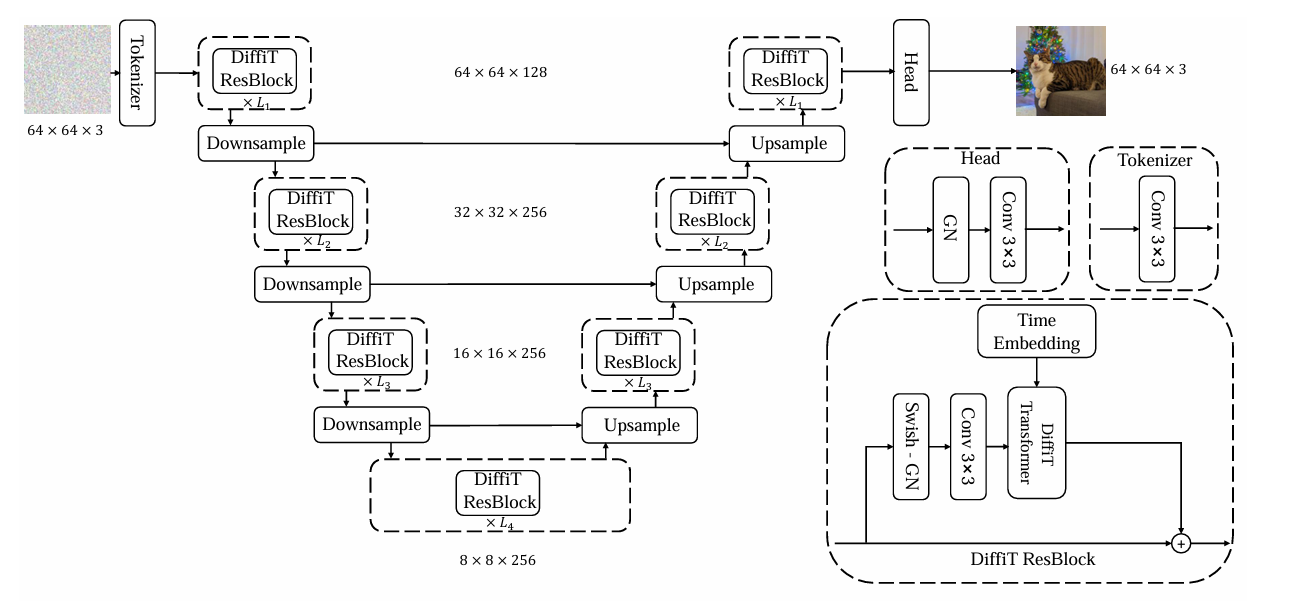





In [ ]:
class ImageDiffiT(nn.Module):  # TODO Maybe implement "learn sigma"
    """
    Diffusion model based on U-Net architecture with a DiffitResBlock backbone.
    More information can be found here:
    https://arxiv.org/pdf/2312.02139
    DiffiT: Diffusion Vision Transformers for Image Generation
    by. Ali Hatamizadeh, Jiaming Song, Guilin Liu, Jan Kautz, Arash Vahdat
    """

    def __init__(self, img_size, l1=4, l2=4, l3=4, patch_size=2, num_classes=1000, class_dropout_prob=0.1,
                 hidden_size=1152, channels=3, hidden_channels=128, num_heads=16, num_groups=8):
        """
        :param l1: number of sequential Diffit Block in the first U-Net level
        :param l2: number of sequential Diffit Block in the second U-Net level
        :param l3: number of sequential Diffit Block in the third U-Net level
        :param patch_size: size of the patches to divide the input image.
        :param channels: number of channels in the input image.
        :param hidden_channels: number of hidden channels in the intermediate layers.
            Must be divisible by num_groups.
        :param hidden_size: size of the latent vector representation used inside the network.
            It must be divisible by num_heads.
        :param num_heads: the number of heads in the DiffitBlock transformer.
        :param class_dropout_prob: probability of dropping out class during training.
        :param num_classes: the total number of classes.
        """
        super(ImageDiffiT, self).__init__()
        assert hidden_size % num_heads == 0, 'hidden_size must be divisible by num_heads'
        assert hidden_channels % num_groups == 0, 'hidden_channels must be divisible by num_groups'
        self.num_classes = num_classes
        self.tokenizer = Tokenizer(in_channels=channels, out_channels=hidden_channels)
        self.t_embedder = TimestepEmbedder(hidden_size=hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)

        def get_block_params(block_groups, block_img_size, hidden_channels):
            """
            Returns the parameters to use in the DiffiTResBlock blocks.
            """
            return {
                "num_heads": num_heads, "patch_size": patch_size, "img_size": block_img_size,
                "hidden_size": hidden_size, "channels": hidden_channels, "num_groups": block_groups
            }

        self.resBlock1 = DiffiTSequential.all_equals(l1, **get_block_params(1, img_size, hidden_channels))
        self.downsample_1 = nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=3, stride=2, padding=1)
        self.resBlock2 = DiffiTSequential.all_equals(l2, **get_block_params(num_groups, img_size // 2, hidden_channels*2))
        self.downsample_2 = nn.Conv2d(hidden_channels*2, hidden_channels*2, kernel_size=3, stride=2, padding=1)
        self.resBlock3 = DiffiTSequential.all_equals(l3, **get_block_params(num_groups, img_size // 4, hidden_channels*2))
        self.upsample_1 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels*2, kernel_size=4, stride=2, padding=1)
        self.resBlock2up = DiffiTSequential.all_equals(l2, **get_block_params(num_groups, img_size // 2, hidden_channels*2))
        self.upsample_2 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, kernel_size=4, stride=2, padding=1)
        self.resBlock1Up = DiffiTSequential.all_equals(l1, **get_block_params(1, img_size, hidden_channels))
        self.head = Head()
        self.initialize_weights()

    def initialize_weights(self):
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

        self.apply(_basic_init)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

    def forward(self, x, t, y):
        """
        Forward pass of the ImageDiffiT model.

        :param x: (batch_size, channels, input_size, input_size) tensor of spatial inputs (squared image)
        :param t: (batch_size,) tensor of diffusion timesteps, one per each image
        :param y: (batch_size,) tensor of class labels, one per each image
        :return: (batch_size, channels, input_size, input_size) tensor of spatial outputs (squared image)
        """
        # Generate embeddings for timesteps and labels
        xt = self.t_embedder(t)  # Timestep embedding: (batch_size, hidden_size)
        xl = self.y_embedder(y)  # Label embedding: (batch_size, hidden_size)
        c = xt + xl  # Combine timestep and label embeddings: (batch_size, hidden_size)

        # Tokenize input image
        x1 = self.tokenizer(x)  # Convert image to feature maps: (batch_size, hidden_channels, input_size, input_size)
        # Encoder (downsampling) path
        x1 = self.resBlock1(x1, c)  # First level of U-Net: (batch_size, hidden_channels, input_size, input_size)
        x2 = self.downsample_1(x1)  # Downsample to half resolution: (batch_size, hidden_channels, input_size/2, input_size/2)
        x2 = self.resBlock2(x2, c)  # Second level of U-Net: (batch_size, hidden_channels, input_size/2, input_size/2)
        x3 = self.downsample_2(x2)  # Downsample to quarter resolution: (batch_size, hidden_channels, input_size/4, input_size/4)
        x3 = self.resBlock3(x3, c)  # Third level of U-Net: (batch_size, hidden_channels, input_size/4, input_size/4)

        # Decoder (upsampling) path with skip connections
        x2 = x2 + self.upsample_1(x3)  # Upsample and add skip connection: (batch_size, hidden_channels, input_size/2, input_size/2)
        x2 = self.resBlock2up(x2,c)  # Process upsampled features: (batch_size, hidden_channels, input_size/2, input_size/2)
        x1 = x1 + self.upsample_2(x2)  # Upsample and add skip connection: (batch_size, hidden_channels, input_size, input_size)JU
        x1 = self.resBlock1Up(x1,c)  # Process final upsampled features: (batch_size, hidden_channels, input_size, input_size)

        # Generate final output
        x = self.head(x1)  # Convert feature maps to output image: (batch_size, channels, input_size, input_size)

        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of the model with a 3-channels classifiers free guidance.
        Basically it works in the following way:
        - The input x is repeated twice creating a new batch.
        - The input t is repeated twice creating a new batch.
        - The input y is concatenated to a batch of the same size in which each element is a "null" label ( which in
        this case is "null_classes" ).
        The model will predict the noise of each image 2 times: one guided ( when there is the label ) and
        one not guided ( when the label is "null" ).
        The process is applied only to the first 3 channels.

        :param cfg_scale: the classifier-free-guidance scale. It's a parameter. The highest the number is, the more the
         conditioning has importance.
        :param x: (batch_size, channels, input_size, input_size) tensor of spatial inputs (squared image)
        :param t: (batch_size,) tensor of diffusion timesteps, one per each image.
        :param y: (batch_size,) tensor of class labels, one per each image.
        :return: (batch_size*2, channels, input_size, input_size) tensor of spatial inputs (squared image)
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        combined = torch.cat([x, x], dim=0)
        combined_times = torch.cat([t, t], dim=0)
        null_labels = torch.full((x.shape[0],),
                                 self.num_classes)  # "self.num_classes" is the special class for "no class"
        combined_labels = torch.cat([y, null_labels], dim=0)
        model_out = self.forward(combined, combined_times, combined_labels)
        # Eps: first 3 channels
        # Rest: remaining channels ( usually none )
        eps, rest = model_out[:, :3], model_out[:, 3:]
        # This is only about the first 3 channels
        # cond_eps: noise generated conditionally
        # uncond_eps: noise generated unconditionally.
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        # The noise is combined between the 2 using the weight "cfg scale"
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        # The batch is "doubled" going back to the original shape TODO why is it useful? Can't we just use half?
        eps = torch.cat([half_eps, half_eps], dim=0)
        # The three channels are combined with the rest - untouched
        return torch.cat([eps, rest], dim=1)

## **Tokenizer**

#### The tokenizer is implemented as a convolutional layer. The output feature map is composed by 128 channels.

In [ ]:
class Tokenizer(nn.Module):
    """
    Tokenizer module that applies a 2D convolutional layer ( with 3x3 Kernel )  to the input.
    It creates more features maps.
    More information can be found here:
    https://arxiv.org/pdf/2312.02139
    DiffiT: Diffusion Vision Transformers for Image Generation
    by. Ali Hatamizadeh, Jiaming Song, Guilin Liu, Jan Kautz, Arash Vahdat
    """

    def __init__(self, in_channels=3, out_channels=128):
        """
        :param in_channels: number of input channels of the input image.
        :param out_channels: number of output feature maps.
        """
        super(Tokenizer, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, 3, 1, 1)

    def forward(self, x):
        """
        Forward pass of the tokenizer.

        :param x: Input tensor of shape (batch_size, in_channels,  height, width).
        :return: Output tensor after applying convolution of shape (batch_size, out_channels, height, width).
        """
        x = self.conv2d(x)
        return x

## **Head**
#### The decoding head is a group normalization layer followed by a convolutional layer. The output is a 3-channels image.

In [ ]:
class Head(nn.Module):
    """
    Head module consisting of Group Normalization followed by a 2D convolutional layer.
    More information can be found here:
    https://arxiv.org/pdf/2312.02139
    DiffiT: Diffusion Vision Transformers for Image Generation
    by. Ali Hatamizadeh, Jiaming Song, Guilin Liu, Jan Kautz, Arash Vahdat
    """

    def __init__(self, in_channels=128, out_channels=3, num_groups=8):
        """
        :param in_channels: number of input channels of the input.
        It must be divisible by num_groups.
        :param out_channels: number of output feature maps.
        :param num_groups: number of groups to divide the input tensor for group normalization.
        """
        super(Head, self).__init__()
        assert in_channels % num_groups == 0, "in_channels must be divisible by num_groups"
        self.groupNorm = nn.GroupNorm(num_groups, in_channels)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        """
        :param x: Input tensor of shape (batch_size, in_channels, height, width).
        :return: Output tensor of shape (batch_size, channels, height, width).
        """
        x = self.groupNorm(x)
        x = self.conv2d(x)
        return x

## **DiffiT Residual Blocks**  
#### The residual DiffiT blocks is composed of the following layers:


1. Group normalization
2. Swish activation function
3. Convolutional layer
4. Patch embedding layer + learnable positional embedding
5. DiffiT layer
6. Final linear layer to re-obtain original number of features.
7. Unpatchify layer to re-obtain the original image shape



In [ ]:
class DiffiTResBlock(nn.Module):
    """
    Residual block that applies GroupNorm, SiLU activation, a convolutional layer, and the DiffiT module to the input.
    More information can be found here:
    https://arxiv.org/pdf/2312.02139
    DiffiT: Diffusion Vision Transformers for Image Generation
    by. Ali Hatamizadeh, Jiaming Song, Guilin Liu, Jan Kautz, Arash Vahdat
    """

    def __init__(self, img_size, num_heads=16, patch_size=2, hidden_size=1152, channels=128, num_groups=8):
        """
        :param img_size: size of the input image, assumed squared.
        :param num_heads: number of heads of the DiffiT.
        :param patch_size: patch size for which the image has to be divided in for the vision transformer.
        :param hidden_size: hidden size of the embeddings. Must be divisible by num_heads.
        :param channels: number of channels of the feature map. Must be divisible by num_groups.
        :param num_groups: number of groups to divide the input tensor for group normalization.
        """
        super(DiffiTResBlock, self).__init__()
        assert hidden_size % num_heads == 0, 'hidden_size must be divisible by num_heads'
        assert channels % num_groups == 0, 'patch_size must be divisible by num_groups'
        self.channels = channels
        self.groupNorm = nn.GroupNorm(channels//4, channels)
        self.swish = nn.SiLU()
        self.conv2d = nn.Conv2d(channels, channels, 3, 1, 1)
        self.diffit = DiffTBlock(hidden_size, num_heads)
        self.x_embedder = PatchEmbed(img_size, patch_size, channels, hidden_size, bias=True)

        self.patch_size = patch_size
        self.num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, hidden_size), requires_grad=False)
        self.final = FinalLayer(hidden_size, patch_size, self.channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

    def unpatchify(self, x):
        """
        Transforms a batch of series of patches to a batch of unpatched images.
        :param x: Input tensor of size (batch_size, T, patch_size**2 * C)
        :return: Output tensor of size (batch_size, H, W, C)
        """
        c = self.channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, c):
        """
        :param x: Input tensor of shape (batch_size, channels, height, width).
        :param c: Context tensor for attention of size (batch_size, hidden_size), one for each input.
            It's usually a combination of label and temporal embedding.
        :return: Output tensor of shape (batch_size, channels, height, width).
        """
        x = self.conv2d(self.swish(self.groupNorm(x)))
        # Encoding input to pass it to transformer
        x_patched = self.x_embedder(x) + self.pos_embed
        x = self.unpatchify(self.final(self.diffit(x_patched, c))) + x  # (batch_size, channels, height, width)
        return x

In [ ]:
class DiffiTSequential(nn.Module):
    """
    Just a sequential version of DiffiTResBlock, so that will be executed sequentially.
    """

    def __init__(self, *blocks):
        """
        :param blocks: a bunch of DiffiTResBlocks.
        """
        super(DiffiTSequential, self).__init__()
        self.blocks = nn.ModuleList(blocks)

    @staticmethod
    def all_equals(n, **kwargs):
        """
        Returns an instance of DiffiTSequential having n blocks with same input parameters.
        :param n: Nr of blocks.
        :param kwargs: parameters of class "DiffiTResBlock".
        :return: an instance of DiffiTSequential having n blocks with same input parameters.
        """
        return DiffiTSequential(*[DiffiTResBlock(**kwargs) for _ in range(n)])

    def forward(self, x, c):
        """
        :param x: Input tensor of shape (batch_size, channels, height, width).
        :param c: Context tensor for attention of size (batch_size, hidden_size), one for each input.
            It's usually a combination of label and temporal embedding.
        :return: Output tensor of shape (batch_size, channels, height, width).
        """
        for block in self.blocks:
            x = block(x, c)  # Assuming each block takes x and xt
        return x

# **LATENT SPACE MODEL**
The latent space model is a simple variation of the Vision Transformer model. Instead of working directly with images, it works with a latent reppresentation of a pre-trained autoencoder model.
The architecture is composed by the following - sequential - layers:
1. Encoder layer: from the autoencoder, to obtain the latent reppresentation of the image. It's applied before the noisification of the image.
2. Patch embedding layer: the image is pachified and learnable positional embedding is summed.
3. N layers of Latent DiffiT modules: in the orginal implementation 30 layers are used.
4. Final layer: to re-obtain the original number of features of the feature map. It's a linear layer.
5. Unpatchify layer: to bring the feature map to the original shape.
6. Decoder layer: from the autoencoder, to obtain an image from the latent reppresentation. It's applied during the backtracking phase only during inference time.

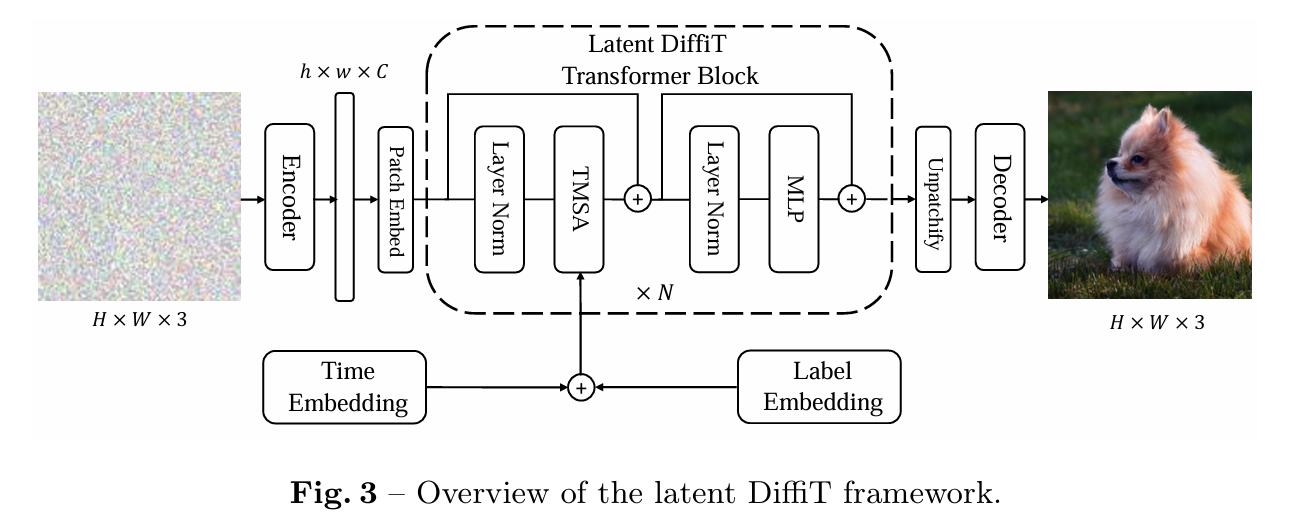



In [ ]:
class LatentDiffiT(nn.Module):
    """
    Diffusion model with a Transformer backbone which uses the latent space of the model.
    The image is encoded and decoded by a pretrained variational autoencoders, and processed by batch_size layers of the
    DiffiT Block.
    More information can be found here:
    https://arxiv.org/pdf/2312.02139
    DiffiT: Diffusion Vision Transformers for Image Generation
    by. Ali Hatamizadeh, Jiaming Song, Guilin Liu, Jan Kautz, Arash Vahdat
    """

    def __init__(
            self,
            encode_size=32,
            patch_size=2,
            channels=3,
            hidden_size=1152,
            depth=30,
            num_heads=16,
            mlp_ratio=4.0,
            class_dropout_prob=0.1,
            num_classes=1000,
    ):
        """
        :param autoencoder: the autoencoders model used to encode and decode the input. It must have the following methods:
            - encode(input) returns a tensor of shape [batch_size, seq_len, hidden_size]
            - decode(input): returns a tensor of shape [batch_size, img_size, img_size]
            Recommended to use autoencoders.pretraiend_autoencoder.PretrainedAutoEncoder
        :param encode_size: height and width of the input image - assumed to be square - after the encoding.
        :param patch_size: size of the patches to divide the input image.
        :param channels: number of channels in the input image.
        :param hidden_size: size of the latent vector representation used inside the network.
            It must be divisible by num_heads.
        :param depth: number of DiffitBlocks.
        :param num_heads: the number of heads in the DiffitBlock transformer.
        :param mlp_ratio: Ratio of the hidden size of the MLP to the input hidden size in the DiffitBlock.
        :param class_dropout_prob: probability of dropping out class during training.
        :param num_classes: the total number of classes.
        """
        super().__init__()
        assert hidden_size % num_heads == 0, 'hidden_size must be divisible by num_heads'

        self.num_classes = num_classes
        self.channels = channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(encode_size, patch_size, channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        self.num_patches = self.x_embedder.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, hidden_size), requires_grad=False)
        self.blocks = nn.ModuleList([
            DiffTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final = FinalLayer(hidden_size, patch_size, self.channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

    def unpatchify(self, x):
        """
        Transforms a batch of series of patches to a batch of unpatched images.
        :param x: Input tensor of size (batch_size, T, patch_size**2 * C)
        :return: Output tensor of size (batch_size, H, W, C)
        """
        c = self.channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        :param x: (batch_size, channels, input_size, input_size) tensor of spatial inputs (squared image)
        :param t: (batch_size,) tensor of diffusion timesteps, one per each image.
        :param y: (batch_size,) tensor of class labels, one per each image.
        :return: (batch_size, channels, input_size, input_size) tensor of spatial inputs (squared image)
        """

        # Patchify the latent representation and adding positional embedding to patches
        x = self.x_embedder(x) + self.pos_embed
        # (batch_size, num_patches, hidden_size), where num_patches = (new_input_size / patch_size ) ** 2
        # Creating embedding of time steps
        t = self.t_embedder(t)  # (batch_size, hidden_size)
        # Creating embedding of class labels
        y = self.y_embedder(y, self.training)  # (batch_size, hidden_size)
        # Summing time and label embedding
        c = t + y  # (batch_size, hidden_size)
        # Passing through all the DiffiT blocks
        for block in self.blocks:
            x = block(x, c)  # (batch_size, num_patches, hidden_size)
        # Passing to final layer to allow correct unpatchify module
        x = self.final(x)  # ( batch_size, num_patches, patch_size**2 * new_channels )
        # Transforming patches into actual latent representations
        x = self.unpatchify(x)  # (batch_size, new_channels, new_input_size, new_input_size )
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of the model with a 3-channels classifiers free guidance.
        Basically it works in the following way:
        - The input x is repeated twice creating a new batch.
        - The input t is repeated twice creating a new batch.
        - The input y is concatenated to a batch of the same size in which each element is a "null" label ( which in
        this case is "null_classes" ).
        The model will predict the noise of each image 2 times: one guided ( when there is the label ) and
        one not guided ( when the label is "null" ).
        The process is applied only to the first 3 channels.

        :param cfg_scale: the classifier-free-guidance scale. It's a parameter. The highest the number is, the more the
         conditioning has importance.
        :param x: (batch_size, channels, input_size, input_size) tensor of spatial inputs (squared image)
        :param t: (batch_size,) tensor of diffusion timesteps, one per each image.
        :param y: (batch_size,) tensor of class labels, one per each image.
        :return: (batch_size*2, channels, input_size, input_size) tensor of spatial inputs (squared image)
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        combined = torch.cat([x, x], dim=0)
        combined_times = torch.cat([t, t], dim=0)
        null_labels = torch.full((x.shape[0],),
                                 self.num_classes)  # "self.num_classes" is the special class for "no class"
        combined_labels = torch.cat([y, null_labels], dim=0)
        model_out = self.forward(combined, combined_times, combined_labels)
        # Eps: first 3 channels
        # Rest: remaining channels ( usually none )
        eps, rest = model_out[:, :3], model_out[:, 3:]
        # This is only about the first 3 channels
        # uncond_eps: noise generated unconditionally.
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        # The noise is combined between the 2 using the weight "cfg scale"
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        # The batch is "doubled" going back to the original shape TODO why is it useful? Can't we just use half?
        eps = torch.cat([half_eps, half_eps], dim=0)
        # The three channels are combined with the rest - untouched
        return torch.cat([eps, rest], dim=1)

In [ ]:
class FinalLayer(nn.Module):
    """
    The final layer of DiffiT. It's necessary to transform the tensor to the necessary shape to unpatchify it correctly.
    """

    def __init__(self, hidden_size, patch_size, out_channels):
        """
        :param hidden_size: dimensionality of the input embeddings.
        :param patch_size: patch size used to patch the input image.
        :param out_channels: number of output channels the image should have.
        """
        super().__init__()
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)

    def forward(self, x):
        """
        :param x: Input tensor of shape (batch_size, seq_len, hidden_size).
        :return: Output tensor of shape (batch_size,seq_len, patch_size * patch_size * out_channels).
        """
        x = self.linear(x)
        return x

## **AUTOENCODER**
#### Load pretrained autoencoder needed for latent space model implementation.
##### The latent space model works with the latent reppresentations of the images. The encoding and decoding phases are executed by a pre-trained autoencoder ( ref. https://github.com/CompVis/latent-diffusion ), which is the same cited by the original paper. In particular, the images are encoded in a feature map of shape 32x32x4.
#### To stabilyze the training process, the encodings are multiplied by a constant ( 0.18215 ).

In [ ]:
class PretrainedAutoEncoder(nn.Module):
    """
    A class to automatically load the pretrained autoencoders from https://github.com/CompVis/latent-diffusion.
    It's necessary to download the correct weights from the GitHub.
    """

    def __init__(self, weights_file, device, model_config='kl_32x32x4'):
        """

        :param weights_file: the path to the downloaded weights file.
        Careful! Each model has its own right config file to choose.
        :param model_config: the config of the pretrained autoencoders to use. Possible values are:
            'kl_64x64x3', 'kl_32x32x4', 'kl_16x16x16', 'kl_8x8x64'
            The configuration ( with associated model ) decides the shape of the encoded input.
        """
        super().__init__()
        config_files = {
            'kl_8x8x64': 'autoencoder_kl_8x8x64.yaml',
            'kl_16x16x16': 'autoencoder_kl_16x16x16.yaml',
            'kl_32x32x4': 'autoencoder_kl_32x32x4.yaml',
            'kl_64x64x3': 'autoencoder_kl_64x64x3.yaml',
        }

        assert model_config in config_files.keys(), 'model_config must be one of {}'.format(list(config_files.keys()))

        config_path =  os.path.join('/content/diffit-reimplementation/autoencoders/configs', config_files[model_config])
        # Load the configuration
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)

        # Instantiate the model
        model_config = config['model']
        self.model = instantiate_from_config(model_config).to(device)
        # Load the pre-trained weights
        state_dict = torch.load(weights_file, map_location=device)["state_dict"]
        self.model.load_state_dict(state_dict)

    def encode(self, x):
        """
        Encodes the input x using the pretrained autoencoders.
        :param x: (batch_size, channels, input_size, input_size) tensor of spatial inputs (squared image)
        :return: (batch_size, new_channels, new_input_size, new_input_size) tensor of encoded inputs.
        """
        return self.model.encode(x).sample()

    def decode(self, x):
        """
        Decodes the input x using the pretrained autoencoders.
        :param x: (batch_size, new_channels, new_input_size, new_input_size) tensor of encoded spatial inputs (squared image)
        :return: (batch_size, new_channels, new_input_size, new_input_size) of decoded spatial inputs (squared image)
        """
        return self.model.decode(x)

    def forward(self, *args, **kwargs):
        return self.encode(*args, **kwargs)

    def to(self, *args, **kwargs):
        self.model.to(*args, **kwargs)

# **DATASET PREPARATION**
The dataset preprocessing consisted of the following steps:
1. Images normalization: the colors have been normalized to the interval [-1,+1].
2. Class sampling: only a sub-portion of the dataset is included, keeping only 50% of the total classes. This operation was applied to make the training process more lightweight, due to the limited power of the available hardwer (colab).

In [ ]:
def prepare_dataset(base_folder_path, dataset_name):

  # Define the transformations to apply to the data
  transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
              ])

  if dataset_name == 'imagenet_256':
    dataset_folder = os.path.join(base_folder_path, dataset_name + '_dataset')

    dataset = datasets.ImageFolder(
            root=dataset_folder,
            transform=transform
        )

    dataset_sampled, _ = sample_dataset_by_class(dataset, 50)
    num_classes = max(dataset_sampled.targets) + 1
    print(f"the number of classes is: {num_classes}")

    # suddivision of dataset indices into train, test and validation sets
    train_indices, test_indices = train_test_split(
        range(len(dataset_sampled)), test_size=0.15, stratify=dataset_sampled.targets, random_state=42
    )

    # creation of train, test and validation subsets of the dataset
    train_dataset = Subset(dataset_sampled, train_indices)
    test_dataset = Subset(dataset_sampled, test_indices)

    # Print dataset sizes
    print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

  elif dataset_name == 'cifar10':
      # Download the CIFAR-10 dataset. It consists of 60K of 32x32 color images in 10 classes, with 6K images per
      # class. There are 50K training images and 10K test images.
      train_dataset = datasets.CIFAR10(root=base_folder_path, train=True,
                                              download=True, transform=transform)
      test_dataset = datasets.CIFAR10(root=base_folder_path, train=False,
                                            download=True, transform=transform)

      num_classes = max(train_dataset.targets) + 1
      print(f"the number of classes is: {num_classes}")


  return train_dataset, test_dataset , num_classes

In [ ]:
def sample_dataset_by_class(dataset, num_classes_to_sample, seed=42):
    """Samples a dataset to include a specified number of classes.

    Args:
        dataset: The original dataset.
        num_classes_to_sample: The percentage of classes to sample.
        seed: Random seed for reproducibility.

    Returns:
        A Subset of the original dataset containing only the sampled classes.
    """
    # Set random seed for reproducibility
    np.random.seed(seed)

    # Get unique classes and sample from them
    unique_classes = np.unique(dataset.targets)
    num_total_classes = len(unique_classes)
    num_classes_to_sample = int(num_total_classes * (num_classes_to_sample/100) )   # Calculate the number of classes to sample

    sampled_classes = np.random.choice(unique_classes, size=num_classes_to_sample, replace=False)

    # Create a mapping from original class labels to renumerated labels
    class_mapping = {original: new for new, original in enumerate(sampled_classes)}
    # Create a list of indices corresponding to the sampled classes
    sampled_indices = []
    renumerated_targets = []
    for i in range(len(dataset)):
        if dataset.targets[i] in sampled_classes:
            sampled_indices.append(i)
            renumerated_targets.append(class_mapping[dataset.targets[i]])  # Add the renumerated label

    # Create a Subset using the sampled indices
    subset = Subset(dataset, sampled_indices)

    # Update the subset to include renumerated labels
    subset.targets = renumerated_targets  # Assign the new labels to the subset

    return subset, class_mapping

# **TRAINING**


## **Training process**

In [ ]:
class DiffiTTrainer:
    def __init__(self, model_type, train_dataloader, model, optimizer, loss_function, device, save_folder,
                 batch_size, num_epochs, num_classes, noise_scheduler, autoencoder, checkpoint_path=None):
      self.model_type = model_type
      self.train_dataloader = train_dataloader
      self.model = model
      self.optimizer = optimizer
      self.loss = loss_function
      self.device = device
      self.save_folder = save_folder
      self.num_epochs = num_epochs
      self.num_classes = num_classes
      self.batch_size = batch_size
      self.noise_scheduler = noise_scheduler
      self.autoencoder = autoencoder

      self.history = {
          "NUM_EPOCHS": num_epochs,
          "BATCH_SIZE": batch_size,
          "LEARNING_RATE": optimizer.param_groups[0]['lr'],
          "train_loss": []
      }

      self.start_epoch = 1  # Default starting epoch
      self.save_path = None
      if checkpoint_path:
          self.load_checkpoint(checkpoint_path)

    def save_checkpoint(self, epoch, save_path):
      checkpoint = {
          'model_state_dict': self.model.state_dict(),
          'optimizer_state_dict': self.optimizer.state_dict(),
          'epoch': epoch,
          'history': self.history,
          'expr_folder': save_path
      }
      checkpoint_path = os.path.join(save_path, f'checkpoint_{epoch}.pth')
      torch.save(checkpoint, checkpoint_path)
      print(f"Checkpoint saved at: {checkpoint_path}")

    def load_checkpoint(self, checkpoint_path):
      checkpoint = torch.load(checkpoint_path, map_location=self.device)
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      self.start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
      self.history = checkpoint['history']
      self.save_path = checkpoint['expr_folder']
      print(f"Checkpoint loaded. Resuming from epoch {self.start_epoch}.")

    def train_one_batch(self, x, y):

      # sample timesteps (tensor of (batch_size,) dimension)
      t = torch.randint(0, self.noise_scheduler.T, (x.shape[0],), device=self.device)

      noise, x_noisy = self.noise_scheduler.noisify(x, t)
      pred = self.model(x_noisy, t, y)
      loss = self.loss(pred, noise)

      # Backward pass and optimization
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss.item()

    def validate_loss(self, x, y):
      t = torch.randint(0, self.noise_scheduler.T, (x.shape[0],), device=self.device)
      noise, x_valid_noisy = self.noise_scheduler.noisify(x, t)
      pred = self.model(x_valid_noisy, t, y)
      loss = self.loss(pred, noise)
      return loss.item()

    def train(self):

      if self.save_path == None:
        t = datetime.now()
        minute = str(t.minute).zfill(2)
        daytime = f"{t.year}-{t.month}-{t.day}-{t.hour}-{minute}"

        self.save_path = os.path.join(self.save_folder, daytime)

        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

      train_total_batches = len(self.train_dataloader)
      best_val_loss = float('inf')

      for epoch in range(self.start_epoch, self.num_epochs + 1):
        # TRAINING
        train_epoch_loss = 0.0
        self.model.train()

        for x_train, y_train in tqdm(self.train_dataloader, desc=f'TRAINING - Epoch {epoch}/{self.num_epochs}'):
          x_train, y_train = x_train.to(self.device), y_train.to(self.device)
          if self.model_type == 'latent':
            with torch.no_grad():
                z_train = self.autoencoder.encode(x_train).mul_(0.18215) # 0.18215 is a scale factor that ensures to have
                                                                         # the latent space with a unit variance. This is
                                                                         # important to have a stable training and
                                                                         # consistent sampling.
            torch.cuda.empty_cache()
            train_batch_loss = self.train_one_batch(z_train, y_train)
          else:
            train_batch_loss = self.train_one_batch(x_train, y_train)

          train_epoch_loss += train_batch_loss

        avg_train_epoch_loss = train_epoch_loss / train_total_batches
        print(f"Epoch {epoch}/{self.num_epochs} - Training Loss: {avg_train_epoch_loss}")

        if epoch % 10 == 0:
            sampled_images = sample_imgs(self.model, self.device, self.noise_scheduler, self.num_classes)
            sampled_images = denormalize(sampled_images)
            # Plot and save generated images
            #plot_images(sampled_images)
            save_image(sampled_images, os.path.join(self.save_path, f"{epoch}.jpg"), nrow=5, normalize=False)
            # Save history
            self.history["train_loss"].append(avg_train_epoch_loss)
            self.save_checkpoint(epoch, self.save_path)

      # Save training history
      history_df = pd.DataFrame(self.history)
      history_path = os.path.join(self.save_path, f'history.csv')
      history_df.to_csv(history_path, index=False)

      return self.history


## **Training executions**

The two DiffiT architectures are trained with two different datasets:
- **Latent space** is trained on ImageNet256 with 50% of the total classes;
- **Image space** is trained on CIFAR-10, which consists of 60K of 32x32 color images in 10 classes, with 6K images per class. There are 50K training images and 10K test images.

Training the models with the hyperparameters given in the original paper, we discovered that our computational resources were not sufficient. In order to obtain results, we reduced the dimension of the two models, changing some hyperparameters, and we modified the loss function, using the *SmoothL1Loss*. It smoothly transitions from L1 (absolute error) to L2 (squared error) loss depending on the magninute of the error, balancing the benefits of both. In particular:
- for **small errors**, it behaves like **L2 loss**, which provides a stable grandient;
- for **large errors**, it behaves like **L1 loss**, which is less sensitive to outliers.

It is useful in our context because stabilize the training, makes it faster and more robust to noisy data.


### **Model loading**

In [ ]:
def prepare_model(model_type, num_classes, config_file: str = 'train_parameters.yaml') -> None:
    """
    Trains a latent model based on parameters specified in a YAML configuration file.

    :param config_file: Path to the YAML file containing training parameters.
    """

    if model_type == 'latent':
      param_types = {
        # Dataset settings
        'img_size': int,  # Size of the images represented in the latent space

        # Training settings
        'epochs': int,  # Number of epochs for training
        'batch_size': int,  # Batch size for training
        'learning_rate': (float, int),  # Learning rate for the optimizer
        'test_size': float,  # Fraction of data used for testing (between 0 and 1)
        'random_seed': int,  # Random seed for reproducibility
        'loss_function': str,  # Loss function (e.g., 'MSELoss')

        # Model settings
        'autoencoder_checkpoint': str,  # Path to the pre-trained autoencoder checkpoint
        'channels': int,  # Number of input/output channels
        'patch_size': int,  # Patch size for the model (used in transformer-based models)
        'hidden_size': int,  # Size of the latent sapce in the model
        'depth': int,  # Number of layers in the model
        'num_heads': int,  # Number of attention heads in transformer-based models
        'mlp_ratio': (float, int),  # Ratio for MLP hidden dimension in transformer models
        'class_dropout_prob': float,  # Dropout probability for classification layers

        # Diffusion settings
        'diffusion_steps': int,  # Number of the diffusion steps in the diffusion process
        'beta_start': float,  # Beta start for noise generation
        'beta_end': float,  # Bend end for noise generation
      }
      params = load_parameters(config_file, param_types)
      results_dir_path = '/content/drive/MyDrive/DiffiT_Data/results/latent_DiffiT'

      if not os.path.exists(results_dir_path):
           os.makedirs(results_dir_path)

      save_folder = results_dir_path

      model = LatentDiffiT(
          encode_size=params['encode_size'],
          patch_size=params['patch_size'],
          channels=params['channels'],
          hidden_size=params['hidden_size'], # in the paper is set to 1152
          depth=params['depth'], # in the paper is set to 30
          num_heads=params['num_heads'], # in the paper is set to 16
          mlp_ratio=params['mlp_ratio'], # specified in section H.2 in the paper
          class_dropout_prob=params['class_dropout_prob'],
          num_classes=num_classes #params['num_classes']
      )
    else:
      param_types = {
        # Dataset settings
        'img_size': int,  # Size of the input images (e.g., 256)

        # Training settings
        'epochs': int,  # Number of epochs for training
        'batch_size': int,  # Batch size for training
        'learning_rate': (float, int),  # Learning rate for the optimizer
        'random_seed': int,  # Random seed for reproducibility

        # Model settings
        'channels': int,  # Number of input/output channels
        'patch_size': int,  # Patch size for the model (used in transformer-based models)
        'hidden_size': int,  # Size of the latent sapce in the model
        'num_heads': int,  # Number of attention heads in transformer-based models
        'class_dropout_prob': float,  # Dropout probability for classification layers
        'num_groups': int,  # Number of channel groups to divide the input for group normalization
        'hidden_channels': int,  # Number of channels used in the autoencoder stages
        'l1': int,  # number of sequential Diffit Block in the first U-Net level
        'l2': int,  # number of sequential Diffit Block in the second U-Net level
        'l3': int,  # number of sequential Diffit Block in the third U-Net level

        # Diffusion settings
        'diffusion_steps': int,  # Number of the diffusion steps in the diffusion process
        'beta_start': float,  # Beta start for noise generation
        'beta_end': float,  # Bend end for noise generation
      }
      params = load_parameters(config_file, param_types)
      results_dir_path = '/content/drive/MyDrive/DiffiT_Data/results/image_DiffiT'

      if not os.path.exists(results_dir_path):
           os.makedirs(results_dir_path)

      save_folder = results_dir_path
      model = ImageDiffiT(
          l1=params['l1'],
          l2=params['l2'], # section I.1 in the paper
          l3=params['l3'], # section I.1 in the paper
          img_size=params['img_size'],
          patch_size=params['patch_size'],
          channels=params['channels'],
          hidden_size=params['hidden_size'],
          num_heads=params['num_heads'],
          class_dropout_prob=params['class_dropout_prob'],
          num_classes=num_classes,
          num_groups=params['num_groups'],
          hidden_channels=params['hidden_channels']
      )

    return model, params, save_folder

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
# device inizialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training using: {device}")

# Set the seed
seed = 42

# Set random seed for reproducibility of numpy operations
np.random.seed(seed)

# Set the seed for CPU
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the seed for CUDA (for all devices)
if torch.cuda.is_available():
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
    torch.cuda.manual_seed_all(seed)  # For all CUDA devices

#torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

Training using: cuda
Using CUDA: Tesla T4


### **Latent space model training**

In [ ]:
autoencoder_checkpoint_path = '/content/drive/MyDrive/DiffiT_Data/model.ckpt'
autoencoder_pretrained = PretrainedAutoEncoder(autoencoder_checkpoint_path, device)
train_dataset, test_dataset, num_classes = prepare_dataset('/content/drive/MyDrive/DiffiT_Data', 'imagenet_256')
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

model, params, save_folder = prepare_model('latent', num_classes, latent_config_file)
model = model.to(device)
noise_scheduler = NoiseScheduler(
        diffusion_steps=params['diffusion_steps'],
        beta_start=params['beta_start'],
        beta_end=params['beta_end'],
    )

autoencoders.models.autoencoder.AutoencoderKL
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


KeyboardInterrupt: 

In [ ]:
# parallelization in the case of multiple available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

loss = getattr(nn, 'SmoothL1Loss')() # MSE in the paper
optimizer = optim.Adam(model.parameters(), params['learning_rate'])
trainer = DiffiTTrainer(model_type='latent',
                        train_dataloader=train_dataloader,
                        model=model,
                        optimizer=optimizer,
                        loss_function=loss,
                        device=device,
                        save_folder=save_folder,
                        batch_size=params['batch_size'], # 512 in the paper
                        num_epochs=params['epochs'], # 20000 in the paper
                        num_classes=num_classes, # 1000 in the paper
                        noise_scheduler=noise_scheduler,
                        autoencoder=autoencoder_pretrained
                    )
trainer.train()

### **Image Space model training**

In [ ]:
train_dataset, test_dataset, num_classes = prepare_dataset('/content/drive/MyDrive/DiffiT_Data', 'cifar10')

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
the number of classes is: 10


In [ ]:
model, params, save_folder = prepare_model('image', num_classes, img_config_file)
model = model.to(device)

noise_scheduler = NoiseScheduler(
        diffusion_steps=params['diffusion_steps'],
        beta_start=params['beta_start'],
        beta_end=params['beta_end'],
    )

In [ ]:
# parallelization in the case of multiple available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

loss = getattr(nn, 'SmoothL1Loss')()
optimizer = optim.Adam(model.parameters(), params['learning_rate'])
trainer = DiffiTTrainer(model_type='image',
                        train_dataloader=train_dataloader,
                        model=model,
                        optimizer=optimizer,
                        loss_function=loss,
                        device=device,
                        save_folder=save_folder,
                        batch_size=params['batch_size'], # 512 in the paper
                        num_epochs=params['epochs'], # 20000 in the paper
                        noise_scheduler=noise_scheduler,
                        autoencoder=None
                    )
trainer.train()

TypeError: DiffiTTrainer.__init__() missing 1 required positional argument: 'num_classes'

### **Graphical Loss evolution**


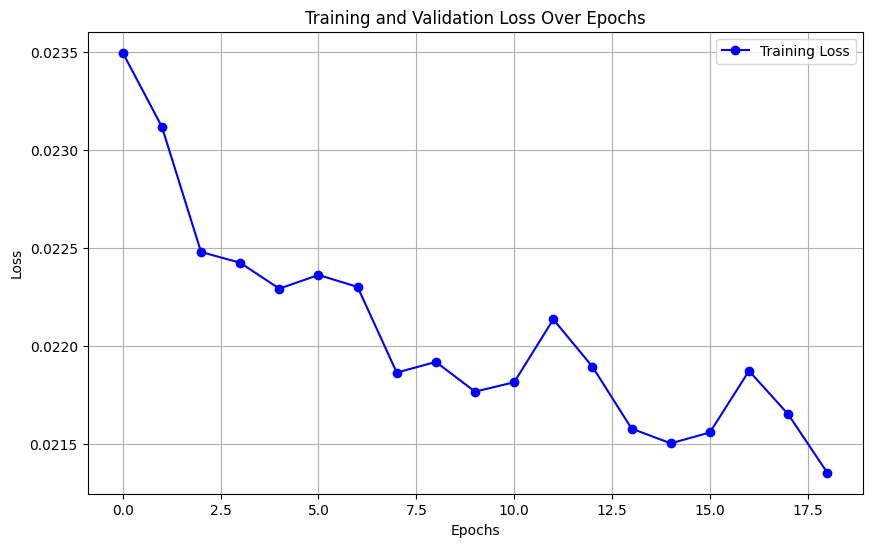

In [ ]:
## PLOT OF LOSS EVOLUTION ##
## NOTE! the evolution is saved every 10 epochs ##
file_path = "/content/drive/MyDrive/DiffiT_Data/results/history_200_final.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, skiprows=[1])

# list of epochs
epochs = [i for i in range(0, 19)]
# list of training loss values
train_loss = df['train_loss']

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", color="blue", marker="o")

# Add labels, title, and legend
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()

# **METRICS AND RESULTS**

## **FID Score**
The FID ( Fréchet inception distance ) score is a metrics which evaluates the quality of the generated images. The latest compares the generated image's embedding mean and variance with the original's.

$$ d_{F} =(\mathcal{N}(μ, Σ), \mathcal{N}(μ', Σ'))^2 = \| μ - μ'  \| + tr(Σ + Σ' - 2( Σ Σ' )^{\frac{1}{2}}$$


In [ ]:
@torch.no_grad()
def extract_from_dataloader(dataloader, class_idx, num_images):
    """
    Extract a specific number of images belonging to a given class from a DataLoader.

    Args:
        dataloader: DataLoader object.
        class_idx: Index of the desired class.
        num_images: Number of images to extract.

    Returns:
        List of (image, label) tuples for the specified class.
    """
    selected_images = []

    # Iterate through the DataLoader
    for images, labels in dataloader:
        # Find images belonging to the specified class
        mask = labels == class_idx
        class_images = images[mask]

        # Add to the selected list
        for img in class_images:
            selected_images.append(img)
            if len(selected_images) >= num_images:
                # Check the results
                print(f"Extracted {len(selected_images)} images.")
                for i, img in enumerate(selected_images):
                    print(f"Image {i+1}")

                selected_images = torch.stack(selected_images)
                return selected_images

    return

In [ ]:
@torch.no_grad()
def fid_computation(test_dataloader, generated_images, eval_batch_size, c, device):

    real_extracted_images = extract_from_dataloader(test_dataloader, c, eval_batch_size).to(device)
    generated_images = torch.tensor(generated_images.to(device))

    real_extracted_images = (real_extracted_images.clamp(-1, 1) + 1) / 2

    plot_images(real_extracted_images)
    plot_images(generated_images)

    # Initialize the FID metric
    fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

    # Update FID metric with generated features
    fid.update(generated_images, real=False)

    # Update FID metric with real features
    fid.update(real_extracted_images, real=True)

    # Compute the FID score
    fid_score = fid.compute()

    return fid_score

In [ ]:
torch.cuda.empty_cache()
real_generated_images, fid_score = sample_imgs(model, 8, 2, device, noise_scheduler, num_classes)

## **RESULTS**  
**Image Space implementation**:

despite the time and hardware limitations, our results demonstrate the model’s ability to generate images of different classes effectively. To handle the memory constraints in Google Colab, we implemented specific adjustments. In particular, we reduced the batch size from 512 to 16 and limited the number of training epochs from 20,000 to 200. These modifications were necessary to manage memory usage efficiently while maintaining the model’s capacity to learn and generalize. While our images do not yet match the quality of those in the original paper, they are well far from pure noise, confirming that the model is learning meaningful representations. With more powerful hardware, we could have trained the model under the same conditions as the original study, potentially achieving comparable results. Nonetheless, our findings highlight that, even under restricted computational resources, the model can generate diverse and recognizable outputs.

**Latent Space implementation**:

with the Latent Space implementation, we were unable to complete the training due to memory limitations. In this case, the additional presence of the autoencoder further increased memory requirements, making it impractical to proceed with the available resources. The storage of both the generator and discriminator parameters, combined with the autoencoder’s weights, significantly exceeded the memory capacity, leading not only to training failures but also to a considerable slowdown in the learning process. These constraints highlight the computational challenges associated with training more complex architectures in environments with limited hardware resources.


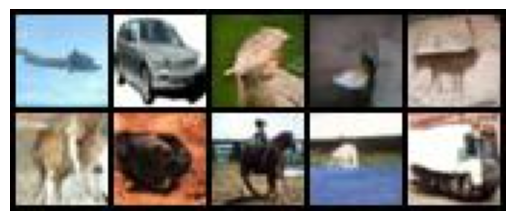

In [ ]:
# Percorso dell'immagine
image_path = "/content/drive/MyDrive/DiffiT_Data/results/200.jpg"

# Caricare e visualizzare
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')  # Rimuove gli assi
plt.show()

# **Conclusions**  
The TMSA mechanism clearly shows improvements in transformer-based diffusion models, allowing to performed a more controlled image generation.
This model reimplementation explored the architecture and TMSA mechanism for image generation. Despite hardware constraints and the following downscalings, the trained model demonstrated basic capabilities in learning shapes and colors.


